In [292]:
import os, sys, glob
import math
import numpy as np
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
mpl.rc('text', usetex=True)
sns.set_context("notebook", font_scale=1.75)

In [274]:
df = pd.read_csv("tracerx.tsv", sep="\t")

In [277]:
df

,patient,n,tree,k,min_mut,max_mut,RSS,BIC,norm_RSS
0,CRUK0001,7,1,0,2043,2043,10553.3000,1896.216000,0.152871
1,CRUK0001,7,1,1,272,1771,5721.9300,1530.435000,0.112565
2,CRUK0001,7,1,2,272,1170,4803.4280,1458.423000,0.103135
3,CRUK0001,7,1,3,272,1170,4558.2600,1468.790000,0.100469
4,CRUK0001,7,1,4,84,1170,4381.8670,1487.840000,0.098505
5,CRUK0001,7,1,5,84,1170,4277.1400,1517.156000,0.097321
6,CRUK0001,7,1,6,84,1170,4217.9970,1553.371000,0.096646
7,CRUK0002,8,1,0,267,267,453.9666,-357.281800,0.027743
8,CRUK0002,8,1,1,48,219,424.2451,-362.778300,0.026819
9,CRUK0002,8,1,2,15,204,413.1877,-336.554300,0.026467


In [275]:
df['norm_RSS'] = np.sqrt(df['RSS']) / (96*df['n'])

In [276]:
def identifyMinBIC(df, patient, tree_idx):
    k = int(df.iloc[df[(df['patient'] == patient) & (df['tree'] == tree_idx)]['BIC'].idxmin()]['k'])
    BIC = df[(df['patient'] == patient) & (df['tree'] == tree_idx)]['BIC'].min()
    RSS = df[(df['patient'] == patient) & (df['tree'] == tree_idx) & (df['k'] == k)]['RSS'].iloc[0]
    norm_RSS = df[(df['patient'] == patient) & (df['tree'] == tree_idx) & (df['k'] == k)]['norm_RSS'].iloc[0]
    return int(k), float(BIC), float(RSS), float(norm_RSS)

In [279]:
df['dRSS'] = 0.
df['rRSS'] = 1.
df['BIC_pref'] = False
df['max_k'] = False
for patient in set(df['patient']):
    for tree_idx in set(df[(df['patient'] == patient)]['tree']):
        k, BIC, RSS, norm_RSS = identifyMinBIC(df, patient, tree_idx)
        K = set(df[(df['patient'] == patient) & (df['tree'] == tree_idx)]['k'])
        max_k = max(K)
        for kk in K:
            idx = df[(df['patient'] == patient) & (df['tree'] == tree_idx) & (df['k'] == kk)]['BIC'].idxmin()
            RSS_kk = float(df.iloc[idx]['RSS'])
            norm_RSS_kk = float(df.iloc[idx]['norm_RSS'])
            df.at[idx, 'dRSS'] = RSS_kk - RSS
            df.at[idx, 'rRSS'] = RSS_kk / RSS
            df.at[idx, 'd_norm_RSS'] = norm_RSS_kk - norm_RSS
            df.at[idx, 'r_norm_RSS'] = norm_RSS_kk / norm_RSS
            df.at[idx, 'BIC_pref'] = kk == k
            df.at[idx, 'max_k'] = kk == max_k

In [280]:
df.head()

,patient,n,tree,k,min_mut,max_mut,RSS,BIC,norm_RSS,dRSS,rRSS,BIC_pref,max_k,d_norm_RSS,r_norm_RSS
0,CRUK0001,7,1,0,2043,2043,10553.300,1896.216,0.152871,5749.872,2.197035,False,False,0.049736,1.482240
1,CRUK0001,7,1,1,272,1771,5721.930,1530.435,0.112565,918.502,1.191218,False,False,0.009430,1.091429
2,CRUK0001,7,1,2,272,1170,4803.428,1458.423,0.103135,0.000,1.000000,True,False,0.000000,1.000000
3,CRUK0001,7,1,3,272,1170,4558.260,1468.790,0.100469,-245.168,0.948960,False,False,-0.002666,0.974146
4,CRUK0001,7,1,4,84,1170,4381.867,1487.840,0.098505,-421.561,0.912237,False,False,-0.004630,0.955111


In [281]:
with open("tracerx_sum.tsv", "w") as f:
    f.write("\t".join(["patient", "n", "tree", "k", 
                       "min_mut", "max_mut", "RSS", "method"]) + "\n")
    for patient in set(df['patient']):
        for tree_idx in set(df[(df['patient'] == patient)]['tree']):
            K = set(df[(df['patient'] == patient) & (df['tree'] == tree_idx)]['k'])
            n = int(df[(df['patient'] == patient) & (df['tree'] == tree_idx) & (df['k'] == 0)]['n'].iloc[0])
            max_k = max(K)
            f.write("\t".join(map(str, [patient, 
                                        n, 
                                        tree_idx, 
                                        0, 
                                        int(df[(df['patient'] == patient) & 
                                               (df['tree'] == tree_idx) & 
                                               (df['k'] == 0)]['min_mut'].iloc[0]),
                                        int(df[(df['patient'] == patient) & 
                                               (df['tree'] == tree_idx) & 
                                               (df['k'] == 0)]['max_mut'].iloc[0]),
                                        float(df[(df['patient'] == patient) & 
                                                  (df['tree'] == tree_idx) & 
                                                  (df['k'] == 0)]['RSS'].iloc[0]),
                                        "min-k"
                                       ])) + "\n")
            f.write("\t".join(map(str, [patient, 
                                        n, 
                                        tree_idx, 
                                        max_k, 
                                        int(df[(df['patient'] == patient) & 
                                               (df['tree'] == tree_idx) & 
                                               (df['k'] == max_k)]['min_mut'].iloc[0]),
                                        int(df[(df['patient'] == patient) & 
                                               (df['tree'] == tree_idx) & 
                                               (df['k'] == max_k)]['max_mut'].iloc[0]),
                                        float(df[(df['patient'] == patient) & 
                                                 (df['tree'] == tree_idx) & 
                                                 (df['k'] == max_k)]['RSS'].iloc[0]),
                                        "max-k"
                                       ])) + "\n")
            f.write("\t".join(map(str, [patient, 
                                        n, 
                                        tree_idx, 
                                        int(df[(df['patient'] == patient) & 
                                             (df['tree'] == tree_idx) & 
                                             (df['BIC_pref'])]['k'].iloc[0]),
                                        int(df[(df['patient'] == patient) & 
                                               (df['tree'] == tree_idx) & 
                                               (df['BIC_pref'])]['min_mut'].iloc[0]),
                                        int(df[(df['patient'] == patient) & 
                                               (df['tree'] == tree_idx) & 
                                               (df['BIC_pref'])]['max_mut'].iloc[0]),
                                        float(df[(df['patient'] == patient) & 
                                               (df['tree'] == tree_idx) & 
                                               (df['BIC_pref'])]['RSS'].iloc[0]),
                                        "BIC-k"
                                       ])) + "\n")

In [282]:
df2 = pd.read_csv("tracerx_sum.tsv", sep="\t")

In [283]:
df2['norm_RSS'] = np.sqrt(df2['RSS']) / (96*df2['n'])

In [284]:
df2['sqrt_RSS'] = np.sqrt(df2['RSS'])

In [285]:
df2['edges'] = df2['n'] - 1

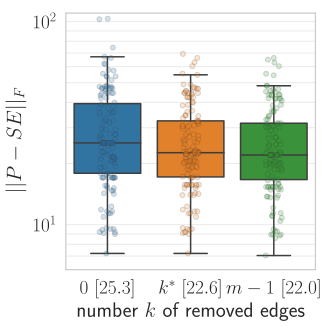

In [311]:
g = sns.boxplot(data=df2[df2['n']>0], x="method", y="sqrt_RSS", order=["min-k", "BIC-k", "max-k"], showfliers=False)
sns.stripplot(data=df2[df2['n']>0], x="method", y="sqrt_RSS", order=["min-k", "BIC-k", "max-k"], jitter=.1, alpha=.2, lw=1)
g.set_ylim((6,110))
g.set_yscale("log")
g.grid(which='both', axis='y', alpha=.4)
g.set_ylabel("$||P-SE||_F$")
g.set_xlabel("number $k$ of removed edges")
g.set_xticklabels(["$0$ $[" + str(round(np.median(df2[df2['method'] == "min-k"].sqrt_RSS), 1)) + "]$", 
                   "$k^*$ $[" + str(round(np.median(df2[df2['method'] == "BIC-k"].sqrt_RSS), 1)) + "]$", 
                   "$m-1$ $[" + str(round(np.median(df2[df2['method'] == "max-k"].sqrt_RSS), 1)) + "]$"])
plt.gcf().set_size_inches(5, 5)
plt.tight_layout()
plt.savefig("tracerx_RSS.pdf")

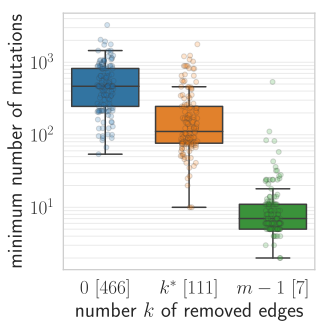

In [310]:
g = sns.boxplot(data=df2[df2['n']>0], x="method", y="min_mut", order=["min-k", "BIC-k", "max-k"], showfliers=False)
sns.stripplot(data=df2[df2['n']>0], x="method", y="min_mut", order=["min-k", "BIC-k", "max-k"], jitter=.1, alpha=.2, lw=1)
# g.set_ylim((6,110))
g.set_yscale("log")
g.grid(which='both', axis='y', alpha=.4)
g.set_ylabel("minimum number of mutations")
g.set_xlabel("number $k$ of removed edges")
g.set_xticklabels(["$0$ $[" + str(int(np.median(df2[df2['method'] == "min-k"].min_mut))) + "]$", 
                   "$k^*$ $[" + str(int(np.median(df2[df2['method'] == "BIC-k"].min_mut))) + "]$", 
                   "$m-1$ $[" + str(int(np.median(df2[df2['method'] == "max-k"].min_mut))) + "]$"])
plt.gcf().set_size_inches(5, 5) 
plt.tight_layout()
plt.savefig("tracerx_min_mut.pdf")

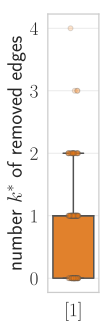

In [297]:
g = sns.boxplot(data=df2[df2['n']>0], x="method", y="k", order=["BIC-k"], showfliers=False, 
                color=sns.color_palette()[1])
sns.stripplot(data=df2[df2['n']>0], x="method", y="k", order=["BIC-k"], jitter=.1, 
              alpha=.2, lw=1, color=sns.color_palette()[1])
# g.set_ylim((-0.5,17))
# g.set_yscale("log")
g.grid(which='both', axis='y', alpha=.4)
g.set_ylabel("number $k^*$ of removed edges")
g.set_xlabel("")
g.set_xticklabels([])
g.set_xticklabels(["$[" + str(int(np.median(df2[df2['method'] == "BIC-k"].k))) + "]$"])
plt.gcf().set_size_inches(2, 5) 
plt.tight_layout()
plt.savefig("tracerx_kstar.pdf")

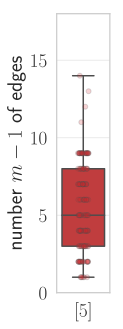

In [314]:
g = sns.boxplot(data=df2[df2['n']>0], x="method", y="edges", order=["BIC-k"], showfliers=False, 
                color=sns.color_palette()[3])
sns.stripplot(data=df2[df2['n']>0], x="method", y="edges", order=["BIC-k"], jitter=.1, 
              alpha=.2, lw=1, color=sns.color_palette()[3])
g.grid(which='both', axis='y', alpha=.4)
g.set_ylim((0,18))
g.set_ylabel("number $m-1$ of edges")
g.set_xlabel("")
g.set_xticklabels(["$[" + str(int(np.median(df2[df2['method'] == "BIC-k"].edges))) + "]$"])
plt.gcf().set_size_inches(2.15, 5)
plt.tight_layout()
plt.savefig("tracerx_edges.pdf")

In [315]:
len(df2[df2['method'] == 'BIC-k'])

143

In [316]:
len(set(df2.patient))

91

In [318]:
max(df2.n)

15